# comp551miniproj2 - reddit text classification

In [26]:
#VARIOUS IMPORTS AND CSV READ INTO DATAFRAME
import logging
import pandas as pd
import numpy as np
from numpy import random
from scipy import sparse
import time
from scipy import sparse
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

df = pd.read_csv('reddit-comment-classification-comp-551/reddit_train.csv')
df = df[pd.notnull(df['comments'])]
print(df.head(10))
print(df['comments'].apply(lambda x: len(x.split(' '))).sum())

X_kaggle = pd.read_csv('reddit-comment-classification-comp-551/reddit_test.csv')
X_kaggle = X_kaggle[pd.notnull(X_kaggle['comments'])]
print(X_kaggle.head(10))
print(X_kaggle['comments'].apply(lambda x: len(x.split(' '))).sum())



   id                                           comments       subreddits
0   0  Honestly, Buffalo is the correct answer. I rem...           hockey
1   1  Ah yes way could have been :( remember when he...              nba
2   2  https://youtu.be/6xxbBR8iSZ0?t=40m49s\n\nIf yo...  leagueoflegends
3   3  He wouldn't have been a bad signing if we woul...           soccer
4   4  Easy. You use the piss and dry technique. Let ...            funny
5   5  The joke is on YOU!\n\nI've only seen it twice...            funny
6   6  His role in MI3 is one of the best villians I'...           movies
7   7  Akagi is still Alpha as fuck and Sugawara is s...            anime
8   8  I think that they had each other's detonator. ...           movies
9   9  Right! He was a disruptor tank! Pull the dps o...        Overwatch
2968210
   id                                           comments
0   0  Trout and Bryant have both led the league in s...
1   1  &gt; Just like Estonians have good reasons to ...
2   2  

The classes are balanced, but the text needs cleaning. Here's some cleaning:

In [3]:
#MISCELLANEOUS PROCESSING
import nltk
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

delimiters = re.compile('[/(){}\[\]\|@,;]')
ignored_symbols = re.compile('[^0-9a-z #+_]')
# nltk.download('stopwords')
stopwords = set(stopwords.words('english'))


def clean_text(text):
    """
        text: a string (one comment)
        return: modified string
    """
#     text = BeautifulSoup(text, "lxml").text # HTML decoding # our pipeline does slightly better without this.
    text = text.lower() # lowercase text
    text = delimiters.sub(' ', text) # replace delimiters symbols by space in text
    text = ignored_symbols.sub('', text) # delete symbols which are in ignored_symbols from text
    text = ' '.join(word for word in text.split() if word not in stopwords) # delete stopwords from text
    return text
    
df['comments'] = df['comments'].apply(clean_text)

#COMPETITION SET
X_kaggle['comments'] = X_kaggle['comments'].apply(clean_text)


Now to lemmatize the corpus.  This might not help in the short term, but will be useful to play with. 


In [4]:
#STEMMERIZE THE WORDS
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer, PorterStemmer
#stemmer = LancasterStemmer()
stemmer = PorterStemmer()
stemmer1 = LancasterStemmer()

def stem_sentence(sen):
    """ stems every word in space separated sentence sen """ 
    token_list = word_tokenize(sen)
    stem_sen = []
    for w in token_list:
#         w= stemmer1.stem(w)
        stem_sen.append(stemmer.stem(w))
    return " ".join(stem_sen)

# Download wordnet (could take a little while!), to do lemmatization
# nltk.download('wordnet')
# from nltk.stem import WordNetLemmatizer 
# lemmatizer = WordNetLemmatizer() 

# def lemm_sentence(sen):
#     """ lemmatizes every word in space separated sentence sen """ 
#     token_list = word_tokenize(sen)
#     lemma_sen = []
#     for w in token_list:
#         lemma_sen.append(lemmatizer.lemmatize(w))
#     return " ".join(lemma_sen)


df['comments'] = df['comments'].apply(lambda x: stem_sentence(x))

print(df.head(10))

#COMPETITION SET
X_kaggle['comments'] = X_kaggle['comments'].apply(lambda x: stem_sentence(x))
X_kaggle = pd.Series(X_kaggle['comments'], index=X_kaggle.index)


   id                                           comments       subreddits
0   0  honestli buffalo correct answer rememb peopl s...           hockey
1   1  ah ye way could rememb draft thought gon na gr...              nba
2   2  http youtub 6xxbbr8isz0t40m49sif didnt find al...  leagueoflegends
3   3  wouldnt bad sign wouldnt paid 18m euro right p...           soccer
4   4  easi use piss dri techniqu let drop let dri ri...            funny
5   5                              joke youiv seen twice            funny
6   6  role mi3 one best villian ive seen movi genuin...           movies
7   7  akagi still alpha fuck sugawara suffer definit...            anime
8   8  think other deton wouldnt proven joker right b...           movies
9   9  right disruptor tank pull dp frey pick get poi...        Overwatch


In [5]:
#GET DISTINCT CLASS NUMBERS FOR ACCURACY LATER
values_array = np.unique(df.subreddits.values)

In [6]:
#SPLIT WHOLE SET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(df.comments, df.subreddits, test_size=0.3, random_state = 100)

## Our own NB

In [7]:
#FIT NAIVE BAYES IMPLEMENTATION
def fit_naive_bayes(observations, y, num_features,smoothing):

    #Initialize marginal probability for each class
    count_class = np.array(20*[[0]])
    marg_prob = np.array(20*[[0]]) #Laplace smoothing, starting counts with 1

    #Initialize matrix of probabilities of observed features given k
    cond_prob_matrix = np.ones((20,num_features)) * smoothing

    
    #compute marginal probability of each class
    total_comments = y.shape[0]
    for j in range(total_comments):
        count_class[y[j]] += 1
    
    #Marginal probability for each class
    marg_prob = np.true_divide(count_class, total_comments)
    
    observ = observations.nonzero()
    j = 0 #counter of comments
    prev_comment_no = observ[0][0] #counter to see if next comment
    for i in range(observations.shape[0]):
        
        feature_no = observ[1][i]
        comment_no = observ[0][i]
        
        if prev_comment_no != comment_no:
            j += comment_no - prev_comment_no
            prev_comment_no = comment_no
            
        comment_class = y[j]
        cond_prob_matrix[comment_class][feature_no] += 1

    #divide each row of cond_prob_matrix by the count of comments per class
    for i in range(20):
        cond_prob_matrix[i] = np.true_divide(cond_prob_matrix[i], count_class[i])

    cond_prob_matrix = cond_prob_matrix.transpose()
    marg_prob = np.log(marg_prob)

    #marg_prob is a vector of 20, cond_prob_matrix a matrix #features rows by 20
    return marg_prob, cond_prob_matrix 

In [16]:
#CONVERT CLASSES TO INT
classes = {
        "anime": 1,
        "AskReddit": 2,
        "baseball": 3,
        "canada": 4, 
        "conspiracy": 5, 
        "europe": 6, 
        "funny": 7, 
        "gameofthrones": 8, 
        "GlobalOffensive": 9,
        "hockey" :10, 
        "leagueoflegends": 11, 
        "movies": 12, 
        "Music": 13, 
        "nba":14, 
        "nfl":15, 
        "Overwatch":16, 
        "soccer":17, 
        "trees":18, 
        "worldnews":19, 
        "wow":0
    }

y_traindf = pd.DataFrame(y_train)
y_traindf['subreddits']= y_traindf['subreddits'].map(classes)
y_train_array = np.array(y_traindf['subreddits'])

y_testdf = pd.DataFrame(y_test)
y_testdf['subreddits']= y_testdf['subreddits'].map(classes)

In [17]:
#PROCESS DE WORDS AND TURN OBSERVATIONS TO BINARY
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=10000,binary=True)
X_train_tf = cv.fit_transform(X_train)
X_test_tf = cv.transform(X_test)
ID_list = X_test.index.tolist()

In [24]:
#FIT OUR NB MODEL
start_time = time.time()
prior, conditional = fit_naive_bayes(X_train_tf, y_train_array, X_train_tf.shape[1],0.01)
print("Took %s seconds." % (time.time() - start_time))

Took 0.2766687870025635 seconds.


In [20]:
#PREDICT FUNCTION
def predict_naive_bayes(id_list, observations, marg_prob, cond_prob_matrix):

    #log of inverse conditional probability matrix
    inv_cond_prob_matrix = np.ones((cond_prob_matrix.shape[0], cond_prob_matrix.shape[1]), dtype=int)
    inv_cond_prob_matrix = inv_cond_prob_matrix - cond_prob_matrix
    inv_cond_prob_matrix = sparse.csr_matrix(np.log(inv_cond_prob_matrix))

    #log of conditional probability matrix
    cond_prob_matrix = sparse.csr_matrix(np.log(cond_prob_matrix))
    
    # 0s become 1s, 1s become 0s
    sparse_ones = sparse.csr_matrix(np.ones((observations.shape[0], observations.shape[1])), dtype=int)
    complement_obs = sparse_ones - observations
    
    prob_per_class = observations.dot(cond_prob_matrix) + complement_obs.dot(inv_cond_prob_matrix)
    
    y = []
    for i in range(observations.shape[0]):
        prob_per_class[i] += marg_prob.transpose()
        y.append(np.argmax(prob_per_class[i]))
        
    id_list = np.array(id_list).transpose()

    matrix = np.stack((id_list, y)).transpose()
    df_pred = pd.DataFrame(matrix)

    return df_pred

In [27]:
#MAKE PREDICTIONS
start_time = time.time()
predictions = predict_naive_bayes(ID_list, X_test_tf, prior, conditional)
print("Took %s seconds." % (time.time() - start_time))

Took 61.35273766517639 seconds.


In [25]:
print(classification_report(y_testdf['subreddits'], predictions[1],target_names=values_array))

                 precision    recall  f1-score   support

      AskReddit       0.32      0.53      0.40      1061
GlobalOffensive       0.23      0.33      0.27      1010
          Music       0.14      0.25      0.17      1052
      Overwatch       0.42      0.25      0.31      1097
          anime       0.26      0.24      0.25      1038
       baseball       0.26      0.23      0.25      1081
         canada       0.23      0.34      0.27      1053
     conspiracy       0.13      0.03      0.05      1043
         europe       0.57      0.39      0.46      1080
          funny       0.40      0.26      0.31      1005
  gameofthrones       0.37      0.24      0.29      1034
         hockey       0.40      0.31      0.35      1021
leagueoflegends       0.31      0.24      0.27      1045
         movies       0.26      0.52      0.35      1064
            nba       0.45      0.30      0.36      1095
            nfl       0.40      0.30      0.35      1034
         soccer       0.35    

In [30]:
import seaborn as sns
def print_confusion_matrix(confusion_matrix, class_names, 
                           figsize = (9,6), fontsize=14, title='Confusion matrix'):
    """Prints a sklearn.metrics.confusion_matrix"""
    accuracy = np.trace(confusion_matrix) / float(np.sum(confusion_matrix))
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
#     heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
#     heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='center')
    heatmap.set_ylim(len(class_names), -0.5)
    plt.ylabel('Actual subreddit')
    plt.xlabel('Predicted subreddit')
    plt.title(title+'\naccuracy={:0.4f}'.format(accuracy))
    plt.tight_layout()

<IPython.core.display.Javascript object>


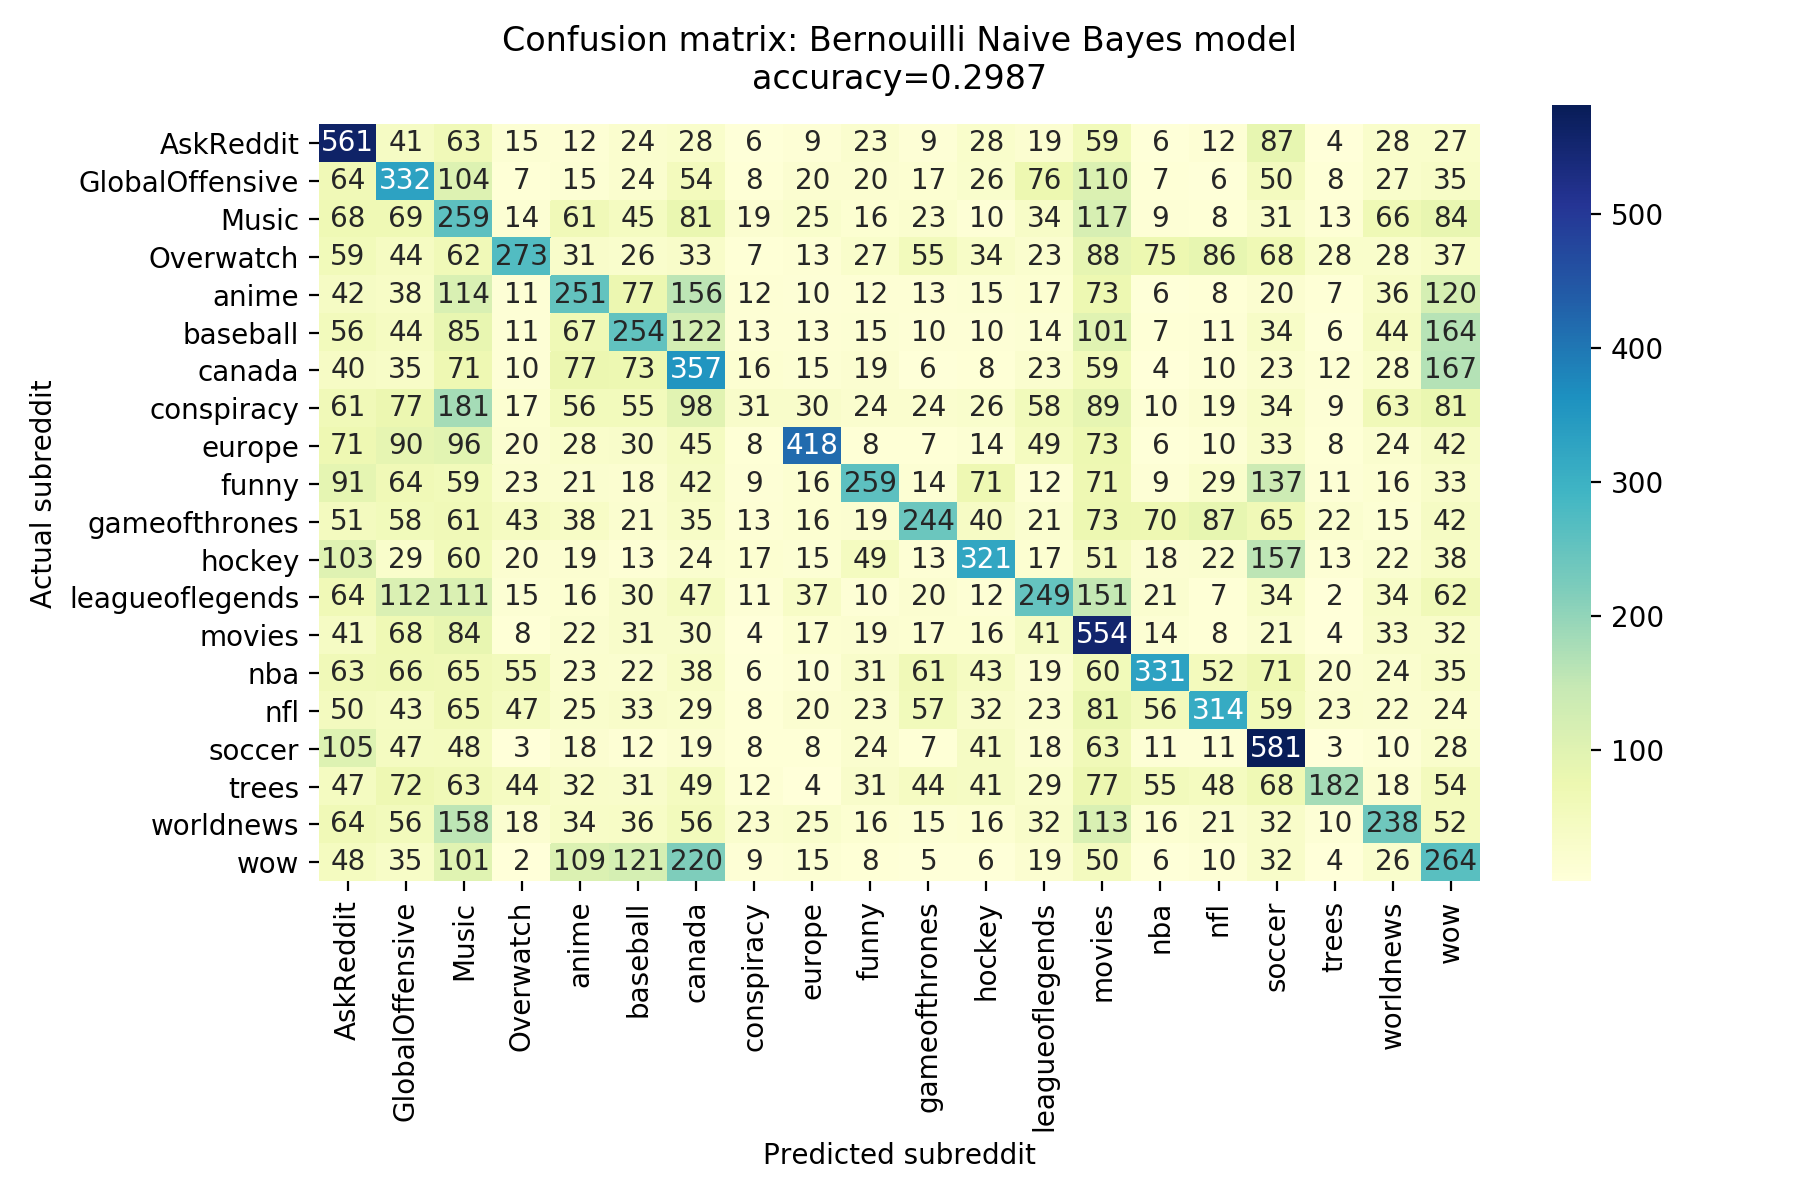

In [32]:
cm = confusion_matrix(y_testdf['subreddits'],predictions[1])
print_confusion_matrix(cm, values_array, 
                       figsize = (9,6), fontsize=14, 
                       title='Confusion matrix: Bernouilli Naive Bayes model')